PCA code copied and adapted from: "Reducing dimensionality with principal component analysis with Python
Optimize the classification of a data set by applying PCA with Python" By Eda Kavlakoglu (https://developer.ibm.com/tutorials/awb-reducing-dimensionality-with-principal-component-analysis/)

In [290]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import os
import pickle
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import CMGDB
import matplotlib

In [291]:
# !!! this needs to match the number of initial conditions in the dataset 
# num_init_cond = 1000

# Load data

# train_file = 'data/Leslie/28.9_29.8_22.0/2train.csv'
# test_file = 'data/Leslie/28.9_29.8_22.0/2test.csv'
# all_pts_file = 'data/Leslie/28.9_29.8_22.0/all_pts.csv'

''' TO DO: Change where model is saved'''

train_file = 'data/arctan/train.csv'
test_file = 'data/arctan/test.csv'
all_pts_file = 'data/arctan/all_pts.csv'

high_dims = 4

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)



header_list_x = [f"x{i}" for i in range(high_dims)]
header_list_y = [f"y{i}" for i in range(high_dims)]
#header_string = ",".join(header_list)


# X_train = train_df[['x0', 'x1', 'x2']]
# Y_train = train_df[['y0', 'y1', 'y2']]

X_train = train_df[header_list_x]
Y_train = train_df[header_list_y]

# last_100 = Y_train.tail(num_init_cond)
# last_100.columns = ['x0', 'x1', 'x2']

all_dynamics_df = pd.read_csv(all_pts_file)
#all_dynamics = all_dynamics_df[['x0', 'x1', 'x2']]#pd.concat([X_train, last_100], axis = 0, ignore_index=True)
all_dynamics = all_dynamics_df[header_list_x]


print(all_dynamics)

X_test = test_df[['x0', 'x1', 'x2']]
Y_test = test_df[['y0', 'y1', 'y2']]

X_test = test_df[header_list_x]
Y_test = test_df[header_list_y]

           x0            x1        x2        x3
0    0.706460  1.708357e+00 -0.554898 -1.843502
1    1.230672  4.270893e-01 -0.138724 -0.460876
2    1.370382  1.067723e-01 -0.034681 -0.115219
3    1.390350  2.669308e-02 -0.008670 -0.028805
4    1.392887  6.673270e-03 -0.002168 -0.007201
..        ...           ...       ...       ...
875 -1.393249 -1.048800e-04 -0.000398 -0.000275
876 -1.393249 -2.622000e-05 -0.000099 -0.000069
877 -1.393249 -6.560000e-06 -0.000025 -0.000017
878 -1.393249 -1.640000e-06 -0.000006 -0.000004
879 -1.393249 -4.100000e-07 -0.000002 -0.000001

[880 rows x 4 columns]


In [292]:
# Scale and center the data (mean zero, sd 1)

feature_names = X_train.columns
Y_train.columns = feature_names
Y_test.columns = feature_names

sc = StandardScaler()
sc.fit(all_dynamics) 

X_train_scaled = sc.transform(X_train)
Y_train_scaled = sc.transform(Y_train)

X_test_scaled = sc.transform(X_test)
Y_test_scaled = sc.transform(Y_test)

all_dynamics_scaled = sc.transform(all_dynamics)

all dynamics_scaled shape: (880, 4)
Number of features: 4
X_train_scaled.T shape: (4, 800)
cov_mat shape: (4, 4)
[[ 9.93470754e-01  3.45476741e-02 -4.20691639e-04 -8.83088816e-02]
 [ 3.45476741e-02  1.09994947e+00  2.50079311e-03  1.00386364e-01]
 [-4.20691639e-04  2.50079311e-03  1.10137671e+00  1.73985499e-02]
 [-8.83088816e-02  1.00386364e-01  1.73985499e-02  1.10041095e+00]]


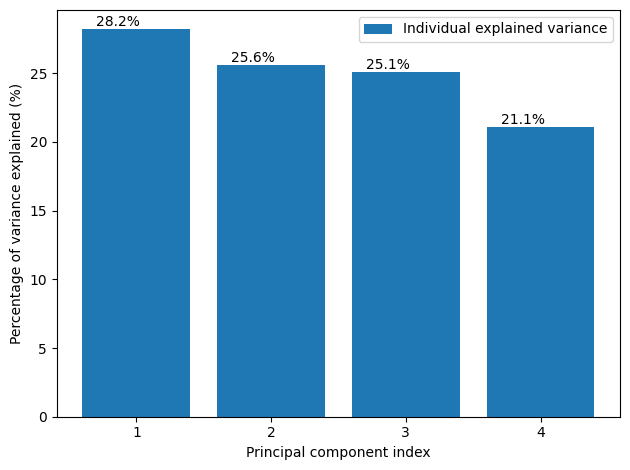

In [293]:
num_features = all_dynamics.shape[1]

print('all dynamics_scaled shape:', all_dynamics.shape)
print(f'Number of features: {num_features}')

print('X_train_scaled.T shape:', X_train_scaled.T.shape)

# covariance matrix, eigenvalues and eigenvectors
cov_mat = np.cov(X_train_scaled.T)

print('cov_mat shape:', cov_mat.shape)
print(cov_mat)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# sort eigenvalues in descending order
eigen_vals = np.sort(eigen_vals)[::-1]

# explained variance percentages
exp_var = [(i / np.sum(eigen_vals)) * 100 for i in eigen_vals]

# plot
bar = plt.bar(range(1, len(exp_var) + 1), exp_var, align='center',
              label='Individual explained variance')

# add % labels on bars
for i, bar in enumerate(bar):
    plt.text(bar.get_x() + bar.get_width() / (num_features - 1), bar.get_height(),
             f'{exp_var[i]:.1f}%', ha='center', va='bottom')

plt.ylabel('Percentage of variance explained (%)')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, len(exp_var) + 1)))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Scree Plot')

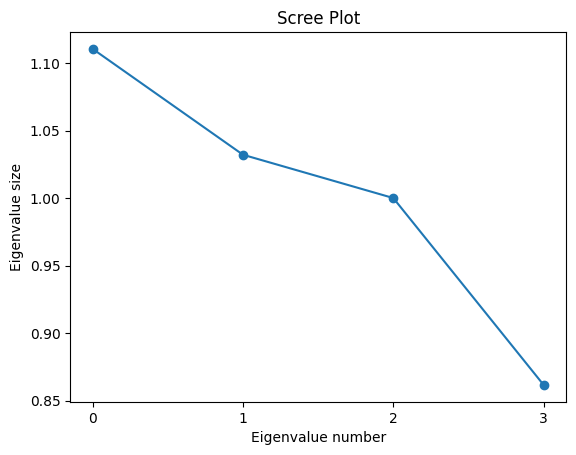

In [294]:
# generate scree plot
pca = PCA()
all_dynamics_scaled_transformed = pca.fit_transform(all_dynamics_scaled)
explained_variance = pca.explained_variance_ratio_
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
x_ticks = list(range(0, len(explained_variance)))
plt.xticks(ticks=x_ticks)
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [295]:
pca_2 = PCA(n_components=2)
pca_2.fit(all_dynamics_scaled)

X_train_pca = pca_2.transform(X_train_scaled)
Y_train_pca = pca_2.transform(Y_train_scaled)

pca_df_X_train = pd.DataFrame(data=X_train_pca, columns=['principal component 1', 'principal component 2'])
pca_df_Y_train = pd.DataFrame(data=Y_train_pca, columns=['principal component 1', 'principal component 2'])

X_test_pca = pca_2.transform(X_test_scaled)
Y_test_pca = pca_2.transform(Y_test_scaled)

pca_df_X_test = pd.DataFrame(data=X_test_pca, columns=['principal component 1', 'principal component 2'])
pca_df_Y_test = pd.DataFrame(data=Y_test_pca, columns=['principal component 1', 'principal component 2'])

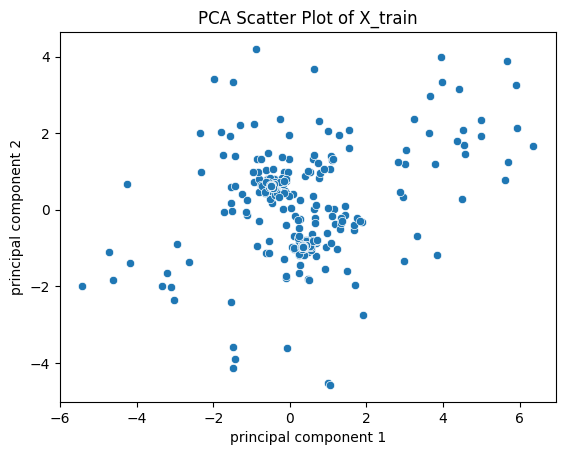

PC1 min: -5.425321124378187, PC1 max: 6.354424957442499
PC2 min: -4.574557239718361, PC2 max: 4.1983425938262044


In [296]:
ax = sns.scatterplot(
    x=pca_df_X_train.iloc[:,0], 
    y=pca_df_X_train.iloc[:,1],
    data=pca_df_X_train,
    legend=True
)

# Add a title
ax.set_title("PCA Scatter Plot of X_train")

plt.show()

# get min and max values for each principal component
pc1_min, pc1_max = pca_df_X_train['principal component 1'].min(), pca_df_X_train['principal component 1'].max()
pc2_min, pc2_max = pca_df_X_train['principal component 2'].min(), pca_df_X_train['principal component 2'].max()

print(f'PC1 min: {pc1_min}, PC1 max: {pc1_max}')
print(f'PC2 min: {pc2_min}, PC2 max: {pc2_max}')

In [297]:
# y_train = pca_df_Y_train.values
# y_test = pca_df_Y_test.values

# y_min = y_train.min(axis=0)
# y_max = y_train.max(axis=0)

# def scale_to_unit_interval(y, y_min, y_max):
#     return 2 * (y - y_min) / (y_max - y_min + 1e-8) - 1

# y_train_scaled = scale_to_unit_interval(y_train, y_min, y_max)
# y_test_scaled = scale_to_unit_interval(y_test, y_min, y_max)

# pca_df_Y_train = pd.DataFrame(y_train_scaled, columns=pca_df_Y_train.columns)
# pca_df_Y_test = pd.DataFrame(y_test_scaled, columns=pca_df_Y_test.columns)

### Latent dynamics model training

#### Load data

In [298]:
X_train_tensor = torch.tensor(pca_df_X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(pca_df_Y_train.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

X_test_tensor = torch.tensor(pca_df_X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(pca_df_Y_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#### Define latent dynamics model

In [299]:
class LatentDynamics(nn.Module):
    def __init__(self, num_layers=high_dims, hidden_shape=124, lower_shape=2):
        super(LatentDynamics, self).__init__()

        self.dynamics = nn.Sequential()
        for i in range(num_layers):
            if i == 0:
                self.dynamics.add_module(f"linear_{i}", nn.Linear(lower_shape, hidden_shape))
            else:
                self.dynamics.add_module(f"linear_{i}", nn.Linear(hidden_shape, hidden_shape))
            self.dynamics.add_module(f"relu_{i}", nn.ReLU(True))
        self.dynamics.add_module(f"linear_{num_layers}", nn.Linear(hidden_shape, lower_shape))
      #  self.dynamics.add_module(f"tanh_{num_layers}", nn.Tanh())
    
    def forward(self, x):
        x = self.dynamics(x)
        return x

#### Define training class and train loop

In [300]:
class Training:
    def __init__(self, train_loader, test_loader, lr=0.001, model_dir='output/Leslie/models', log_dir='output/Leslie/logs', verbose=True):
        self.dynamics = LatentDynamics()
        self.train_loader = train_loader
        self.test_loader = test_loader

        self.lr = lr

        self.model_dir = model_dir
        self.log_dir = log_dir

        self.verbose = bool(verbose)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device: ", self.device)

        self.dynamics.to(self.device)

        self.reset_losses()

        self.dynamics_criterion = nn.MSELoss(reduction='mean')

    def save_models(self, subfolder='', suffix=''):
        save_path = os.path.join(self.model_dir, subfolder)
        os.makedirs(save_path, exist_ok=True)
        torch.save(self.dynamics, os.path.join(save_path, 'dynamics' + suffix + '.pt'))
    
    def load_models(self):
        self.dynamics = torch.load(os.path.join(self.model_dir, 'dynamics_.pt'))
    
    def save_logs(self, suffix=''):
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        
        with open(os.path.join(self.log_dir, 'train_losses_' + suffix + '.pkl'), 'wb') as f:
            pickle.dump(self.train_losses, f)
        
        with open(os.path.join(self.log_dir, 'test_losses_' + suffix + '.pkl'), 'wb') as f:
            pickle.dump(self.test_losses, f)
    
    def reset_losses(self):
        self.train_losses = {'loss_ae1': [], 'loss_ae2': [], 'loss_dyn': [], 'loss_contrastive': [], 'loss_topo': [], 'loss_total': []}
        self.test_losses = {'loss_ae1': [], 'loss_ae2': [], 'loss_dyn': [], 'loss_contrastive': [], 'loss_topo': [], 'loss_total': []}
    
    def forward(self, z_t, z_tau):
        # z_t = E(x_t)
        # z_tau = E(x_tau)

        # z_tau_pred = latent_dynamics(E(x_t))
        z_tau_pred = self.dynamics(z_t)

        return (z_tau, z_tau_pred)

    def dynamics_losses(self, forward_pass):
        z_tau, z_tau_pred = forward_pass
        loss_dyn = self.dynamics_criterion(z_tau_pred, z_tau)
        return loss_dyn
    
    def train(self, epochs=1000, patience=50):

        list_parameters = list(self.dynamics.parameters())
        optimizer = torch.optim.Adam(list_parameters, lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, patience=patience)
        for epoch in tqdm(range(epochs)):

            epoch_train_loss = 0
            epoch_test_loss  = 0

            self.dynamics.train()

            num_batches = len(self.train_loader)
            for (x_t, x_tau) in self.train_loader:
                x_t = x_t.to(self.device)
                x_tau = x_tau.to(self.device)
                optimizer.zero_grad()

                # Forward pass (apply all models)
                forward_pass = self.forward(x_t, x_tau)
                # Compute losses
                loss_dyn = self.dynamics_losses(forward_pass)

                # Backward pass
                loss_dyn.backward()
                optimizer.step()

                epoch_train_loss += loss_dyn.item()

            epoch_train_loss /= num_batches

            self.train_losses['loss_total'].append(epoch_train_loss)

            self.dynamics.eval()
            with torch.no_grad():

                num_batches = len(self.test_loader)
                for (x_t, x_tau) in self.test_loader:
                    optimizer.zero_grad()

                    # Forward pass (apply all models)
                    forward_pass = self.forward(x_t, x_tau)
                    # Compute losses
                    loss_dyn = self.dynamics_losses(forward_pass)

                    epoch_test_loss += loss_dyn.item()

                epoch_test_loss /= num_batches

                self.test_losses['loss_total'].append(epoch_test_loss)

            scheduler.step(epoch_test_loss)
            
            if epoch >= patience:
                if np.mean(self.test_losses['loss_total'][-patience:]) > np.mean(self.test_losses['loss_total'][-patience-1:-1]):
                    if self.verbose:
                        print("Early stopping")
                    break
            
            if self.verbose:
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch + 1, epochs, epoch_train_loss, epoch_test_loss))

#### Train latent dynamics model

In [301]:
trainer = Training(train_loader=train_loader, test_loader=test_loader)
trainer.train()
trainer.save_logs()
trainer.reset_losses()
trainer.save_models()

Device:  cpu


  1%|          | 6/1000 [00:00<00:18, 55.03it/s]

Epoch [1/1000], Train Loss: 0.4606, Test Loss: 0.4551
Epoch [2/1000], Train Loss: 0.4333, Test Loss: 0.4277
Epoch [3/1000], Train Loss: 0.4072, Test Loss: 0.3997
Epoch [4/1000], Train Loss: 0.3802, Test Loss: 0.3713
Epoch [5/1000], Train Loss: 0.3520, Test Loss: 0.3415
Epoch [6/1000], Train Loss: 0.3221, Test Loss: 0.3097


  2%|▏         | 18/1000 [00:00<00:26, 36.58it/s]

Epoch [7/1000], Train Loss: 0.2897, Test Loss: 0.2748
Epoch [8/1000], Train Loss: 0.2537, Test Loss: 0.2376
Epoch [9/1000], Train Loss: 0.2144, Test Loss: 0.1984
Epoch [10/1000], Train Loss: 0.1724, Test Loss: 0.1595
Epoch [11/1000], Train Loss: 0.1298, Test Loss: 0.1244
Epoch [12/1000], Train Loss: 0.0900, Test Loss: 0.0970
Epoch [13/1000], Train Loss: 0.0574, Test Loss: 0.0820
Epoch [14/1000], Train Loss: 0.0385, Test Loss: 0.0806
Epoch [15/1000], Train Loss: 0.0374, Test Loss: 0.0884
Epoch [16/1000], Train Loss: 0.0506, Test Loss: 0.0969
Epoch [17/1000], Train Loss: 0.0654, Test Loss: 0.0986
Epoch [18/1000], Train Loss: 0.0700, Test Loss: 0.0909


  2%|▏         | 23/1000 [00:00<00:29, 33.37it/s]

Epoch [19/1000], Train Loss: 0.0628, Test Loss: 0.0762
Epoch [20/1000], Train Loss: 0.0496, Test Loss: 0.0604
Epoch [21/1000], Train Loss: 0.0369, Test Loss: 0.0489
Epoch [22/1000], Train Loss: 0.0289, Test Loss: 0.0442
Epoch [23/1000], Train Loss: 0.0265, Test Loss: 0.0458
Epoch [24/1000], Train Loss: 0.0285, Test Loss: 0.0506


  3%|▎         | 27/1000 [00:00<00:34, 28.62it/s]

Epoch [25/1000], Train Loss: 0.0321, Test Loss: 0.0551
Epoch [26/1000], Train Loss: 0.0346, Test Loss: 0.0577
Epoch [27/1000], Train Loss: 0.0351, Test Loss: 0.0581
Epoch [28/1000], Train Loss: 0.0335, Test Loss: 0.0572


  3%|▎         | 31/1000 [00:01<00:44, 21.76it/s]

Epoch [29/1000], Train Loss: 0.0308, Test Loss: 0.0549
Epoch [30/1000], Train Loss: 0.0275, Test Loss: 0.0517
Epoch [31/1000], Train Loss: 0.0245, Test Loss: 0.0480


  4%|▍         | 38/1000 [00:01<00:38, 24.73it/s]

Epoch [32/1000], Train Loss: 0.0222, Test Loss: 0.0444
Epoch [33/1000], Train Loss: 0.0209, Test Loss: 0.0417
Epoch [34/1000], Train Loss: 0.0206, Test Loss: 0.0404
Epoch [35/1000], Train Loss: 0.0211, Test Loss: 0.0403
Epoch [36/1000], Train Loss: 0.0220, Test Loss: 0.0403
Epoch [37/1000], Train Loss: 0.0226, Test Loss: 0.0399
Epoch [38/1000], Train Loss: 0.0226, Test Loss: 0.0388


  4%|▍         | 42/1000 [00:01<00:36, 26.44it/s]

Epoch [39/1000], Train Loss: 0.0219, Test Loss: 0.0375
Epoch [40/1000], Train Loss: 0.0208, Test Loss: 0.0366
Epoch [41/1000], Train Loss: 0.0197, Test Loss: 0.0365
Epoch [42/1000], Train Loss: 0.0189, Test Loss: 0.0374
Epoch [43/1000], Train Loss: 0.0187, Test Loss: 0.0389
Epoch [44/1000], Train Loss: 0.0190, Test Loss: 0.0406


  5%|▍         | 48/1000 [00:01<00:36, 26.27it/s]

Epoch [45/1000], Train Loss: 0.0194, Test Loss: 0.0419
Epoch [46/1000], Train Loss: 0.0198, Test Loss: 0.0422
Epoch [47/1000], Train Loss: 0.0198, Test Loss: 0.0415
Epoch [48/1000], Train Loss: 0.0196, Test Loss: 0.0401
Epoch [49/1000], Train Loss: 0.0191, Test Loss: 0.0385
Epoch [50/1000], Train Loss: 0.0186, Test Loss: 0.0371


  6%|▌         | 56/1000 [00:02<00:31, 29.54it/s]

Epoch [51/1000], Train Loss: 0.0183, Test Loss: 0.0363
Epoch [52/1000], Train Loss: 0.0182, Test Loss: 0.0359
Epoch [53/1000], Train Loss: 0.0183, Test Loss: 0.0359
Epoch [54/1000], Train Loss: 0.0184, Test Loss: 0.0360
Epoch [55/1000], Train Loss: 0.0185, Test Loss: 0.0362
Epoch [56/1000], Train Loss: 0.0185, Test Loss: 0.0363
Epoch [57/1000], Train Loss: 0.0184, Test Loss: 0.0364


  6%|▌         | 60/1000 [00:02<00:30, 30.33it/s]

Epoch [58/1000], Train Loss: 0.0182, Test Loss: 0.0364
Epoch [59/1000], Train Loss: 0.0180, Test Loss: 0.0365
Epoch [60/1000], Train Loss: 0.0179, Test Loss: 0.0366
Epoch [61/1000], Train Loss: 0.0178, Test Loss: 0.0366
Epoch [62/1000], Train Loss: 0.0178, Test Loss: 0.0366
Epoch [63/1000], Train Loss: 0.0179, Test Loss: 0.0364


  7%|▋         | 68/1000 [00:02<00:34, 27.30it/s]

Epoch [64/1000], Train Loss: 0.0179, Test Loss: 0.0361
Epoch [65/1000], Train Loss: 0.0179, Test Loss: 0.0359
Epoch [66/1000], Train Loss: 0.0178, Test Loss: 0.0357
Epoch [67/1000], Train Loss: 0.0177, Test Loss: 0.0355
Epoch [68/1000], Train Loss: 0.0176, Test Loss: 0.0354
Epoch [69/1000], Train Loss: 0.0176, Test Loss: 0.0353


  8%|▊         | 78/1000 [00:02<00:27, 34.05it/s]

Epoch [70/1000], Train Loss: 0.0176, Test Loss: 0.0352
Epoch [71/1000], Train Loss: 0.0176, Test Loss: 0.0351
Epoch [72/1000], Train Loss: 0.0176, Test Loss: 0.0350
Epoch [73/1000], Train Loss: 0.0176, Test Loss: 0.0349
Epoch [74/1000], Train Loss: 0.0175, Test Loss: 0.0348
Epoch [75/1000], Train Loss: 0.0175, Test Loss: 0.0347
Epoch [76/1000], Train Loss: 0.0174, Test Loss: 0.0347
Epoch [77/1000], Train Loss: 0.0174, Test Loss: 0.0348
Epoch [78/1000], Train Loss: 0.0174, Test Loss: 0.0350


  9%|▊         | 86/1000 [00:02<00:26, 34.71it/s]

Epoch [79/1000], Train Loss: 0.0174, Test Loss: 0.0351
Epoch [80/1000], Train Loss: 0.0174, Test Loss: 0.0352
Epoch [81/1000], Train Loss: 0.0174, Test Loss: 0.0353
Epoch [82/1000], Train Loss: 0.0173, Test Loss: 0.0353
Epoch [83/1000], Train Loss: 0.0173, Test Loss: 0.0351
Epoch [84/1000], Train Loss: 0.0173, Test Loss: 0.0350
Epoch [85/1000], Train Loss: 0.0173, Test Loss: 0.0348
Epoch [86/1000], Train Loss: 0.0172, Test Loss: 0.0347


 10%|▉         | 95/1000 [00:03<00:24, 37.20it/s]

Epoch [87/1000], Train Loss: 0.0172, Test Loss: 0.0347
Epoch [88/1000], Train Loss: 0.0172, Test Loss: 0.0346
Epoch [89/1000], Train Loss: 0.0172, Test Loss: 0.0347
Epoch [90/1000], Train Loss: 0.0172, Test Loss: 0.0347
Epoch [91/1000], Train Loss: 0.0172, Test Loss: 0.0347
Epoch [92/1000], Train Loss: 0.0172, Test Loss: 0.0347
Epoch [93/1000], Train Loss: 0.0171, Test Loss: 0.0347
Epoch [94/1000], Train Loss: 0.0171, Test Loss: 0.0347
Epoch [95/1000], Train Loss: 0.0171, Test Loss: 0.0346


 10%|█         | 100/1000 [00:03<00:23, 39.04it/s]

Epoch [96/1000], Train Loss: 0.0171, Test Loss: 0.0346
Epoch [97/1000], Train Loss: 0.0171, Test Loss: 0.0346
Epoch [98/1000], Train Loss: 0.0171, Test Loss: 0.0346
Epoch [99/1000], Train Loss: 0.0171, Test Loss: 0.0346
Epoch [100/1000], Train Loss: 0.0170, Test Loss: 0.0346
Epoch [101/1000], Train Loss: 0.0170, Test Loss: 0.0346
Epoch [102/1000], Train Loss: 0.0170, Test Loss: 0.0346
Epoch [103/1000], Train Loss: 0.0170, Test Loss: 0.0346
Epoch [104/1000], Train Loss: 0.0170, Test Loss: 0.0346


 11%|█         | 110/1000 [00:03<00:21, 41.63it/s]

Epoch [105/1000], Train Loss: 0.0170, Test Loss: 0.0346
Epoch [106/1000], Train Loss: 0.0170, Test Loss: 0.0345
Epoch [107/1000], Train Loss: 0.0169, Test Loss: 0.0345
Epoch [108/1000], Train Loss: 0.0169, Test Loss: 0.0345
Epoch [109/1000], Train Loss: 0.0169, Test Loss: 0.0345
Epoch [110/1000], Train Loss: 0.0169, Test Loss: 0.0345
Epoch [111/1000], Train Loss: 0.0169, Test Loss: 0.0345
Epoch [112/1000], Train Loss: 0.0169, Test Loss: 0.0345
Epoch [113/1000], Train Loss: 0.0168, Test Loss: 0.0344


 12%|█▏        | 120/1000 [00:03<00:23, 37.48it/s]

Epoch [114/1000], Train Loss: 0.0168, Test Loss: 0.0344
Epoch [115/1000], Train Loss: 0.0168, Test Loss: 0.0344
Epoch [116/1000], Train Loss: 0.0168, Test Loss: 0.0343
Epoch [117/1000], Train Loss: 0.0168, Test Loss: 0.0344
Epoch [118/1000], Train Loss: 0.0168, Test Loss: 0.0344
Epoch [119/1000], Train Loss: 0.0168, Test Loss: 0.0344
Epoch [120/1000], Train Loss: 0.0167, Test Loss: 0.0343


 13%|█▎        | 129/1000 [00:03<00:22, 38.84it/s]

Epoch [121/1000], Train Loss: 0.0167, Test Loss: 0.0343
Epoch [122/1000], Train Loss: 0.0167, Test Loss: 0.0343
Epoch [123/1000], Train Loss: 0.0167, Test Loss: 0.0342
Epoch [124/1000], Train Loss: 0.0167, Test Loss: 0.0342
Epoch [125/1000], Train Loss: 0.0167, Test Loss: 0.0342
Epoch [126/1000], Train Loss: 0.0167, Test Loss: 0.0342
Epoch [127/1000], Train Loss: 0.0167, Test Loss: 0.0342
Epoch [128/1000], Train Loss: 0.0166, Test Loss: 0.0342
Epoch [129/1000], Train Loss: 0.0166, Test Loss: 0.0342


 14%|█▍        | 139/1000 [00:04<00:20, 41.55it/s]

Epoch [130/1000], Train Loss: 0.0166, Test Loss: 0.0342
Epoch [131/1000], Train Loss: 0.0166, Test Loss: 0.0342
Epoch [132/1000], Train Loss: 0.0166, Test Loss: 0.0342
Epoch [133/1000], Train Loss: 0.0166, Test Loss: 0.0342
Epoch [134/1000], Train Loss: 0.0166, Test Loss: 0.0342
Epoch [135/1000], Train Loss: 0.0166, Test Loss: 0.0342
Epoch [136/1000], Train Loss: 0.0165, Test Loss: 0.0342
Epoch [137/1000], Train Loss: 0.0165, Test Loss: 0.0342
Epoch [138/1000], Train Loss: 0.0165, Test Loss: 0.0342
Epoch [139/1000], Train Loss: 0.0165, Test Loss: 0.0342


 14%|█▍        | 144/1000 [00:04<00:20, 42.49it/s]

Epoch [140/1000], Train Loss: 0.0165, Test Loss: 0.0342
Epoch [141/1000], Train Loss: 0.0165, Test Loss: 0.0342
Epoch [142/1000], Train Loss: 0.0165, Test Loss: 0.0341
Epoch [143/1000], Train Loss: 0.0165, Test Loss: 0.0341
Epoch [144/1000], Train Loss: 0.0164, Test Loss: 0.0341
Epoch [145/1000], Train Loss: 0.0164, Test Loss: 0.0341
Epoch [146/1000], Train Loss: 0.0164, Test Loss: 0.0341
Epoch [147/1000], Train Loss: 0.0164, Test Loss: 0.0340
Epoch [148/1000], Train Loss: 0.0164, Test Loss: 0.0341


 15%|█▌        | 154/1000 [00:04<00:21, 38.92it/s]

Epoch [149/1000], Train Loss: 0.0164, Test Loss: 0.0341
Epoch [150/1000], Train Loss: 0.0164, Test Loss: 0.0341
Epoch [151/1000], Train Loss: 0.0163, Test Loss: 0.0341
Epoch [152/1000], Train Loss: 0.0163, Test Loss: 0.0341
Epoch [153/1000], Train Loss: 0.0163, Test Loss: 0.0340
Epoch [154/1000], Train Loss: 0.0163, Test Loss: 0.0340
Epoch [155/1000], Train Loss: 0.0163, Test Loss: 0.0340
Epoch [156/1000], Train Loss: 0.0163, Test Loss: 0.0339


 16%|█▌        | 158/1000 [00:04<00:21, 38.88it/s]

Epoch [157/1000], Train Loss: 0.0163, Test Loss: 0.0339
Epoch [158/1000], Train Loss: 0.0162, Test Loss: 0.0340
Epoch [159/1000], Train Loss: 0.0162, Test Loss: 0.0340
Epoch [160/1000], Train Loss: 0.0162, Test Loss: 0.0339
Epoch [161/1000], Train Loss: 0.0162, Test Loss: 0.0339
Epoch [162/1000], Train Loss: 0.0162, Test Loss: 0.0339


 17%|█▋        | 168/1000 [00:05<00:26, 31.81it/s]

Epoch [163/1000], Train Loss: 0.0162, Test Loss: 0.0339
Epoch [164/1000], Train Loss: 0.0162, Test Loss: 0.0339
Epoch [165/1000], Train Loss: 0.0161, Test Loss: 0.0339
Epoch [166/1000], Train Loss: 0.0161, Test Loss: 0.0339
Epoch [167/1000], Train Loss: 0.0161, Test Loss: 0.0339
Epoch [168/1000], Train Loss: 0.0161, Test Loss: 0.0338
Epoch [169/1000], Train Loss: 0.0161, Test Loss: 0.0338
Epoch [170/1000], Train Loss: 0.0161, Test Loss: 0.0338


 18%|█▊        | 177/1000 [00:05<00:23, 34.95it/s]

Epoch [171/1000], Train Loss: 0.0160, Test Loss: 0.0339
Epoch [172/1000], Train Loss: 0.0160, Test Loss: 0.0338
Epoch [173/1000], Train Loss: 0.0160, Test Loss: 0.0338
Epoch [174/1000], Train Loss: 0.0160, Test Loss: 0.0339
Epoch [175/1000], Train Loss: 0.0160, Test Loss: 0.0338
Epoch [176/1000], Train Loss: 0.0160, Test Loss: 0.0338
Epoch [177/1000], Train Loss: 0.0160, Test Loss: 0.0338
Epoch [178/1000], Train Loss: 0.0159, Test Loss: 0.0339
Epoch [179/1000], Train Loss: 0.0159, Test Loss: 0.0339


 18%|█▊        | 185/1000 [00:05<00:22, 35.64it/s]

Epoch [180/1000], Train Loss: 0.0159, Test Loss: 0.0339
Epoch [181/1000], Train Loss: 0.0159, Test Loss: 0.0339
Epoch [182/1000], Train Loss: 0.0159, Test Loss: 0.0339
Epoch [183/1000], Train Loss: 0.0159, Test Loss: 0.0339
Epoch [184/1000], Train Loss: 0.0158, Test Loss: 0.0338
Epoch [185/1000], Train Loss: 0.0158, Test Loss: 0.0338
Epoch [186/1000], Train Loss: 0.0158, Test Loss: 0.0338
Epoch [187/1000], Train Loss: 0.0158, Test Loss: 0.0338


 19%|█▉        | 194/1000 [00:05<00:20, 38.50it/s]

Epoch [188/1000], Train Loss: 0.0158, Test Loss: 0.0337
Epoch [189/1000], Train Loss: 0.0158, Test Loss: 0.0337
Epoch [190/1000], Train Loss: 0.0158, Test Loss: 0.0337
Epoch [191/1000], Train Loss: 0.0157, Test Loss: 0.0337
Epoch [192/1000], Train Loss: 0.0157, Test Loss: 0.0337
Epoch [193/1000], Train Loss: 0.0157, Test Loss: 0.0337
Epoch [194/1000], Train Loss: 0.0157, Test Loss: 0.0338
Epoch [195/1000], Train Loss: 0.0157, Test Loss: 0.0337
Epoch [196/1000], Train Loss: 0.0157, Test Loss: 0.0337


 20%|█▉        | 199/1000 [00:05<00:20, 39.90it/s]

Epoch [197/1000], Train Loss: 0.0156, Test Loss: 0.0338
Epoch [198/1000], Train Loss: 0.0156, Test Loss: 0.0337
Epoch [199/1000], Train Loss: 0.0156, Test Loss: 0.0337
Epoch [200/1000], Train Loss: 0.0156, Test Loss: 0.0337
Epoch [201/1000], Train Loss: 0.0156, Test Loss: 0.0336


 21%|██        | 209/1000 [00:06<00:22, 35.64it/s]

Epoch [202/1000], Train Loss: 0.0156, Test Loss: 0.0336
Epoch [203/1000], Train Loss: 0.0155, Test Loss: 0.0337
Epoch [204/1000], Train Loss: 0.0155, Test Loss: 0.0337
Epoch [205/1000], Train Loss: 0.0155, Test Loss: 0.0337
Epoch [206/1000], Train Loss: 0.0155, Test Loss: 0.0336
Epoch [207/1000], Train Loss: 0.0155, Test Loss: 0.0336
Epoch [208/1000], Train Loss: 0.0155, Test Loss: 0.0337
Epoch [209/1000], Train Loss: 0.0154, Test Loss: 0.0337
Epoch [210/1000], Train Loss: 0.0154, Test Loss: 0.0336


 22%|██▏       | 219/1000 [00:06<00:19, 40.09it/s]

Epoch [211/1000], Train Loss: 0.0154, Test Loss: 0.0337
Epoch [212/1000], Train Loss: 0.0154, Test Loss: 0.0336
Epoch [213/1000], Train Loss: 0.0154, Test Loss: 0.0336
Epoch [214/1000], Train Loss: 0.0154, Test Loss: 0.0336
Epoch [215/1000], Train Loss: 0.0153, Test Loss: 0.0335
Epoch [216/1000], Train Loss: 0.0153, Test Loss: 0.0334
Epoch [217/1000], Train Loss: 0.0153, Test Loss: 0.0335
Epoch [218/1000], Train Loss: 0.0153, Test Loss: 0.0334
Epoch [219/1000], Train Loss: 0.0153, Test Loss: 0.0334
Epoch [220/1000], Train Loss: 0.0152, Test Loss: 0.0334


 23%|██▎       | 229/1000 [00:06<00:17, 42.91it/s]

Epoch [221/1000], Train Loss: 0.0152, Test Loss: 0.0335
Epoch [222/1000], Train Loss: 0.0152, Test Loss: 0.0334
Epoch [223/1000], Train Loss: 0.0152, Test Loss: 0.0333
Epoch [224/1000], Train Loss: 0.0152, Test Loss: 0.0334
Epoch [225/1000], Train Loss: 0.0152, Test Loss: 0.0334
Epoch [226/1000], Train Loss: 0.0151, Test Loss: 0.0335
Epoch [227/1000], Train Loss: 0.0151, Test Loss: 0.0334
Epoch [228/1000], Train Loss: 0.0151, Test Loss: 0.0334
Epoch [229/1000], Train Loss: 0.0151, Test Loss: 0.0336
Epoch [230/1000], Train Loss: 0.0151, Test Loss: 0.0335


 24%|██▍       | 239/1000 [00:06<00:16, 44.99it/s]

Epoch [231/1000], Train Loss: 0.0151, Test Loss: 0.0333
Epoch [232/1000], Train Loss: 0.0150, Test Loss: 0.0333
Epoch [233/1000], Train Loss: 0.0150, Test Loss: 0.0332
Epoch [234/1000], Train Loss: 0.0150, Test Loss: 0.0333
Epoch [235/1000], Train Loss: 0.0150, Test Loss: 0.0334
Epoch [236/1000], Train Loss: 0.0150, Test Loss: 0.0334
Epoch [237/1000], Train Loss: 0.0149, Test Loss: 0.0335
Epoch [238/1000], Train Loss: 0.0149, Test Loss: 0.0336
Epoch [239/1000], Train Loss: 0.0149, Test Loss: 0.0334
Epoch [240/1000], Train Loss: 0.0149, Test Loss: 0.0334


 25%|██▍       | 249/1000 [00:07<00:16, 45.35it/s]

Epoch [241/1000], Train Loss: 0.0149, Test Loss: 0.0332
Epoch [242/1000], Train Loss: 0.0148, Test Loss: 0.0334
Epoch [243/1000], Train Loss: 0.0148, Test Loss: 0.0336
Epoch [244/1000], Train Loss: 0.0148, Test Loss: 0.0337
Epoch [245/1000], Train Loss: 0.0148, Test Loss: 0.0334
Epoch [246/1000], Train Loss: 0.0148, Test Loss: 0.0334
Epoch [247/1000], Train Loss: 0.0147, Test Loss: 0.0333
Epoch [248/1000], Train Loss: 0.0147, Test Loss: 0.0336
Epoch [249/1000], Train Loss: 0.0147, Test Loss: 0.0334
Epoch [250/1000], Train Loss: 0.0147, Test Loss: 0.0335


 26%|██▌       | 255/1000 [00:07<00:21, 35.28it/s]

Epoch [251/1000], Train Loss: 0.0146, Test Loss: 0.0336
Epoch [252/1000], Train Loss: 0.0146, Test Loss: 0.0334
Epoch [253/1000], Train Loss: 0.0146, Test Loss: 0.0336
Epoch [254/1000], Train Loss: 0.0146, Test Loss: 0.0334
Epoch [255/1000], Train Loss: 0.0145, Test Loss: 0.0334
Early stopping


#### Compute Morse graph in latent space

In [302]:
from functools import partial

def g_base(x, trainer):
    x_tensor = torch.tensor(x, dtype=torch.float32).to(trainer.device)
    trainer.dynamics.eval()
    with torch.no_grad():
        output_tensor = trainer.dynamics(x_tensor)
    g_x = output_tensor.cpu().numpy()
    return g_x

g = partial(g_base, trainer=trainer)

g([0, 0])

def G(rect):
    return CMGDB.BoxMap(g, rect)

lower_bounds = [pc1_min, pc2_min]
upper_bounds = [pc1_max, pc2_max]

In [303]:
subdiv_min = 8#18 # 30
subdiv_max = 14 #28 # 36 # 40
subdiv_init = 5 # 18
subdiv_limit = 10000

model = CMGDB.Model(subdiv_min, subdiv_max, subdiv_init, subdiv_limit, lower_bounds, upper_bounds, G)

In [304]:
morse_graph, map_graph = CMGDB.ComputeConleyMorseGraph(model)

Compute_Morse_Graph. Initializing root MorseDecomposition
Compute_Morse_Graph. A phase_space -> size () == 32


Compute_Morse_Graph. B phase_space -> size () == 44
Total Grid Memory (can be external) = 984118
Max Memory For Single Grid (must be internal)= 2654
Max SCC Random Access memory use (must be internal)= 272
Max SCC stack memory use (can be external memory) = 296
 ---- SUMMARY ---- 
Internal Memory Requirement = 2926
External Memory Requirement = 984414
Max graph memory size (never stored, however) = 1032
ConleyIndex: calling RelativeMapHomology.
Dimension 0:
 Matrix is 1 x 1
[ 1 ]
ConleyIndex: calling RelativeMapHomology.
Dimension 0:
 Matrix is 1 x 1
[ 1 ]
ConleyIndex: calling RelativeMapHomology.
Dimension 1:
 Matrix is 1 x 1
[ 1 ]


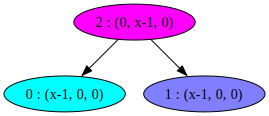

In [305]:
CMGDB.PlotMorseGraph(morse_graph, cmap=matplotlib.cm.cool)

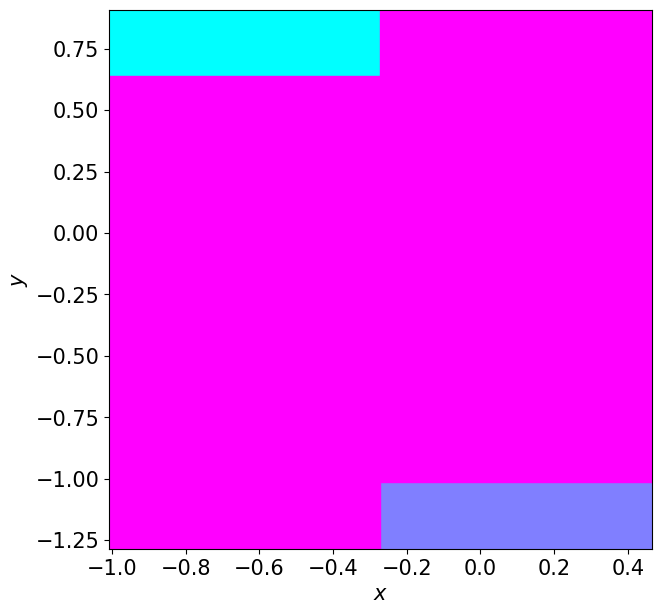

In [306]:
CMGDB.PlotMorseSets(morse_graph, cmap=matplotlib.cm.cool, fig_w=7, fig_h=7)